<div style="border:solid green 2px; padding: 20px">
    
Георгий, привет! Меня зовут Бунакова Влада. Если не возражаешь, предлагаю общаться на «ты» :)

Ниже в файле ты найдешь мои комментарии: <font color='green'>зеленый цвет — «все отлично»; </font> <font color='orange'>желтый — «хорошо, но можно лучше (один-два таких замечаний допустимы, но если их больше — придется исправлять)»; </font> <font color='red'>красный — «нужно исправить».</font> Комментарии в самом коде я отделяю знаками «###». Пожалуйста, не удаляй мои комментарии, они мне нужны при повторной проверке. Будет здорово, если в своих новых комментариях (выделяй их другим цветом) ты напишешь о сделанных тобой изменениях в коде. 


<div style="border:solid green 2px; padding: 20px">
Георгий, спасибо за доработки! Осталось только одно замечание.

<div style="border:solid green 2px; padding: 20px">
Георгий, все в порядке, проект принимаю :)

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предварительная-подготовка" data-toc-modified-id="Предварительная-подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предварительная подготовка</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Модель</a></span></li></ul></div>

# Восстановление золота из руды

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.

## Предварительная подготовка

In [1]:
import pandas as pd
import re
import numpy as np
import time
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import scipy.stats as st
from IPython.display import display_html
from itertools import chain,cycle
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import make_scorer
from warnings import filterwarnings
import seaborn as sns
from sklearn.metrics import r2_score
filterwarnings("ignore")
pd.options.display.max_colwidth = 999

In [2]:
GLOBAL_RANDOM_STATE = 12345

In [3]:
# механизм для манипуляций с данными
class DataHandler:
    def __init__(self):
        self.data = {}
        self.data['train']  = pd.read_csv('/datasets/gold_recovery_train.csv')
        self.data['test'] = pd.read_csv('/datasets/gold_recovery_test.csv')
        self.data['full'] = pd.read_csv('/datasets/gold_recovery_full.csv')
    def columns(self, set: str = 'full', stage: str = '.*', type: str = '.*', param: str = '.*', inc_date=False):
        pattern = re.compile(f'({stage})\.({type})\.({param})')
        cols = list(filter(lambda x: pattern.search(x) != None, self.data[set].columns))
        if inc_date:
            cols.append('date')
        return cols
    def df(self, set: str = 'full', stage: str = '.*', type: str = '.*', param: str = '.*', inc_date=False):
        return self.data[set][self.columns(set, stage, type, param, inc_date)]
    def update_set(self, set: str, df: pd.DataFrame) -> None:
        self.data[set] = df

In [4]:
# общий класс для проведения исследований по конкретной стадии
class StageClass:
    def __init__(self, name='',target=''):
        self.name = name
        self.target = target
    def _reset(self):
        # перечень моделей для тестирования в рамках этапа
        self.estimators = { 
            GradientBoostingRegressor(): {
                'grid': {
                    'n_estimators': [11, 29, 43],
                    'max_depth': [2, 3, 5],
                    'random_state': [GLOBAL_RANDOM_STATE]
                }
            },
            KNeighborsRegressor(): {
                'grid': {
                    'n_neighbors': [73, 181, 317]
                }
            },     
            ElasticNet(): {
                'grid': {
                    'alpha': np.linspace(0.8,1.6,10),
                    'fit_intercept': [True, False],
                    'normalize': [True, False],
                }
            },            
            LinearRegression(): {
                'grid': {
                    'fit_intercept': [True, False],
                    'normalize': [True, False]
                }
            },
            HuberRegressor(): {
                'grid': {
                    'epsilon': np.linspace(1,2,5),
                    'max_iter': list(range(80,120,10)),
                    'fit_intercept': [True,False]                    
                }
            },                         
            PassiveAggressiveRegressor(): {
                'grid': {
                    'C': list(range(1, 10, 1)),
                    'max_iter': list(range(100, 1600, 300)),
                    'random_state': [GLOBAL_RANDOM_STATE]                    
                }
            },                         
            SGDRegressor(): {            
                'grid': {
                    'loss': ['squared_loss', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
                    'penalty': ['l2', 'l1', 'elasticnet'],
                    'power_t': np.linspace(0.1,0.5,3)
                }
            }                          
        } 
    # расчет sMAPE
    @staticmethod
    def smape_error(targ, targ_pred):
        up = np.abs(targ - targ_pred)
        down = (np.abs(targ) + np.abs(targ_pred)) / 2 
        smape = (1/len(up)) * (up / down).sum()
        return smape
 
    # прогон стадии
    def process(self, 
                    ufeat_train: pd.DataFrame, targ_train: pd.Series, 
                    ufeat_test: pd.DataFrame, targ_test: pd.DataFrame,
                    activate=None) -> None:
        start_time = time.perf_counter()
        self._reset()
        feat_train, feat_test = self._scale(ufeat_train, ufeat_test)
        targ_train = targ_train.copy().reset_index(drop=True);
        targ_test = targ_test.copy().reset_index(drop=True);        
        self._gridsearch(feat_train, targ_train, activate)
        self._predict_and_score(feat_train, targ_train, 'pred_train', 'smape_train', activate)
        self._predict_and_score(feat_test, targ_test, 'pred_test', 'smape_test', activate)        
        end_time = time.perf_counter()
        print('Общее время', (end_time-start_time))
    # масштабирование
    def _scale(self, ufeat_train: pd.DataFrame, ufeat_valid: pd.DataFrame) -> list:
        feat_train = ufeat_train.copy().reset_index(drop=True)
        feat_valid = ufeat_valid.copy().reset_index(drop=True)
        scaler = StandardScaler()
        scaler.fit(feat_train[feat_train.columns])
        feat_train[feat_train.columns] = scaler.transform(feat_train[feat_train.columns])
        feat_valid[feat_train.columns] = scaler.transform(feat_valid[feat_train.columns])
        return [feat_train, feat_valid]        

    # предсказания с лучшими параметрами и расчет smape 
    def _predict_and_score(self, 
                                feat: pd.DataFrame, targ: pd.Series,
                                pred_key: str, smape_key: str, activate) -> None:
        for estimator in self.estimators:
            if activate != None:
                if not estimator.__class__.__name__ in activate:
                    continue
            pred = self.estimators[estimator]['best'].predict(feat)
            self.estimators[estimator][pred_key] = pd.Series(pred)
            self.estimators[estimator][smape_key] = StageClass.smape_error(targ, pred)
        
    # подбор гиперпараметров и сохранение лучшей модели для каждого конкретного алгоритма
    def _gridsearch(self, feat: pd.DataFrame, targ: pd.Series, activate) -> None:
        for estimator in self.estimators:
            if activate != None:
                if not estimator.__class__.__name__ in activate:
                    continue
            start_time = time.perf_counter()
            gscv = GridSearchCV(
                estimator,
                self.estimators[estimator]['grid'],
                scoring=make_scorer(StageClass.smape_error, greater_is_better=False),
                cv=5,
                verbose=0,
                return_train_score=True,
                refit=True,
                n_jobs=2
            )
            gscv.fit(feat, targ)
            self.estimators[estimator]['params'] = gscv.best_params_
            self.estimators[estimator]['score'] = gscv.best_score_ * (-1)
            self.estimators[estimator]['best'] = gscv.best_estimator_
            end_time = time.perf_counter()
            print('Выбор гиперпараметров', estimator.__class__.__name__,'для предсказания',self.target,'занял',"{:.3f}".format(end_time-start_time), 'секунд')
    # сводный отчет о результатах
    def report(self):
        frame = pd.DataFrame(
            { 
                "стадия": self.name, 
                "target": self.target, 
                "estimator": [], 
                "лучшие параметры": [], 
                "CV-sMAPE (train)": [],
                "sMAPE (вся train)": [],
                "sMAPE (test)": []
            })
        for estimator in self.estimators:
            if 'best' in self.estimators[estimator]:
                frame.loc[len(frame)] = [
                    self.name,
                    self.target,
                    estimator.__class__.__name__,
                    self.estimators[estimator]['params'], 
                    self.estimators[estimator]['score'], 
                    self.estimators[estimator]['smape_train'], 
                    self.estimators[estimator]['smape_test'], 
                ]
        return frame
            
    def predictions(self, classname: str) -> list:
        for estimator in self.estimators:
            if estimator.__class__.__name__  == classname:
                result = {
                    'pred_train': self.estimators[estimator]['pred_train'], 
                    'pred_test': self.estimators[estimator]['pred_test'] 
                }
                return result
        return None
    

In [5]:
# расчет recovery по формуле из условия
def calculate_recovery(c: pd.Series, f: pd.Series, t: pd.Series) -> pd.Series:
    division = 100 * (c * (f-t)) / (f * (c-t)) 
    # корректировка по результатам анализа train
    division[division < 0] = np.NaN 
    division[division > 100] = np.NaN
    division[division == np.Inf] = np.NaN
    division[division == -np.Inf] = np.NaN
    return division

In [6]:
# выводит смещение метрик descrbe первого фрейма относительного второго
def mean_delta(dfa: pd.DataFrame, dfb: pd.DataFrame) -> pd.DataFrame:
    df = pd.DataFrame()
    tdfa = dfa.describe().transpose()[['mean']]
    tdfb = dfb.describe().transpose()[['mean']]
    return ((tdfa - tdfb) / tdfa).rename(columns={'mean':'mean_delta'})

In [7]:
# заполняет пропуски заначением из фунции-параметра
def fill_with(dfc: pd.DataFrame, func) -> pd.DataFrame:
    df = dfc.copy()
    for col in df.columns:
        df[col] = df[col].fillna(func(df[col]))
    return df    

In [8]:
# потому что локальная лямбда в выоде ниже очень некрасиво смотрится
def zero_fill(x):
    return 0

In [9]:
# перебор разных стратегиий заполнения и вывод результатов
def fill_strategy_comparation(dh, set='.*', stage='.*', type='.*', param='.*', delta_max = 0.05):
    for func in [zero_fill, np.mean, np.median, np.average, np.min, np.max]:
        qty = mean_delta(
                data.df(set=set, stage=stage, type=type, param=param), 
                fill_with(data.df(set=set, stage=stage, param=param),func)
            ).query('mean_delta > @delta_max').shape[0]
        print(f"Число признаков с отклоненями mean > {delta_max * 100}% при замене n/a на {func} = {qty}")

In [10]:
# построение гистограм для одного и более фреймов
def hist(onecolumn_frames_list=[], xlab='', ylab='', title='', bins=10, xrange=None, yrange=None, figsize=(10,5), fontsize=12):
    fig, ax = plt.subplots()
    rmin, rmax = 999999999999999, 0
    series_list, legend_list = [], []
    alpha, alpha_step = 1, int((40 / len(onecolumn_frames_list))) / 100 # полная прозрачность нам не нужна 
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
    for i in series_list:
        rmin = i.min() if i.min() < rmin else rmin
        rmax = i.max() if i.max() > rmax else rmax
        ax.hist(i,bins=bins, alpha=alpha)
        alpha -= alpha_step
    rrange = xrange if xrange != None else (rmin,rmax)
    ax.set_title(title)
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    ax.set_xlim(rrange)
    if yrange != None:
        ax.set_ylim(yrange)
    ax.legend(legend_list)
    fig.set_size_inches(figsize)
    plt.rcParams.update({'font.size': fontsize})
    plt.grid()
    fig.tight_layout()

In [11]:
# построение boxplot для нескольких одноколоночных датафреймов
def boxplot(onecolumn_frames_list=[], xlab='', ylab='', title='', vert=False, figsize=(10,5), fontsize=12, showfliers=True, notch=False):
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize)
    series_list, legend_list, lowers, uppers = [], [], [], []
    label_info = ""
    for i in onecolumn_frames_list:
        column_name = i.columns[0]
        legend_list.append(column_name)
        series_list.append(i[column_name])
        q1 = i[column_name].quantile(0.25)
        q3 = i[column_name].quantile(0.75) 
        iqr = q3 - q1
        median = i[column_name].median()
        mean = i[column_name].mean()
        lower = q1 - 1.5*iqr
        if lower < 0:
            lower = 0
        upper = q3 + 1.5*iqr   
        lowers.append(lower)
        uppers.append(upper)
        label_info += f"\n {column_name}: границы усов = [{round(lower,2)}; {round(upper,2)}], среднее = {round(mean,2)}, медиана = {round(median,2)}, Q1 = {round(q1,2)}, Q3 = {round(q3,2)}" 
        
    bp = ax.boxplot(
        series_list,
        vert=vert,
        patch_artist=True,
        labels=legend_list,
        showfliers=showfliers,
        notch=notch, 
        sym='gs'
    )
    
    colors = ['lightblue', 'lightgreen', 'orange', 'pink', 'yellow','red', 'black', 'green', 'grey', 'blue']
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)  
        
    if vert == False: 
        ax.xaxis.grid(True)
    else: 
        ax.yaxis.grid(True)
        
    ax.set_title(title)
    ax.set_xlabel(xlab + label_info)
    
    ax.set_ylabel(ylab)
    plt.rcParams.update({'font.size': fontsize})
    fig.tight_layout()

In [12]:
# t-test 
def ttest(a, desc_a, b, desc_b):
    a_var = a.var()
    b_var = b.var()
    var_relation =  a_var / b_var if a_var > b_var else b_var / a_var
    ev = var_relation <= 2
    print(f'Подготовка теста: используем equal_vars = {ev}, т.к.')
    print(f'   var({desc_a}) = {a_var}') 
    print(f'   var({desc_b}) = {b_var}') 
    alpha = 0.01
    results = st.ttest_ind(a,b,equal_var=ev) 
    if results.pvalue < alpha:
        print('Результат теста: отвергаем нулевую гипотезу, т.к.', results.pvalue, '<',alpha)
    else: 
        print('Результат тест: нельзя отвергать нулевую гипотезу, т.к.', results.pvalue, '>',alpha)

In [13]:
# отображение нескольких df рядом
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:left"><td style="vertical-align:top">'
        html_str+=f'<h3>{title}</h3>'
        html_str+=df.to_html().replace('table','table style="display: inline; "')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [14]:
# прогон лучшего estimator по стадиям для предсказания
def process_stage(
        stage: str,
        estimator2target: dict, 
        feat_train: pd.DataFrame,
        feat_test: pd.DataFrame) -> dict:
    result = {}
    final_report = None
    for target in ['concentrate_au','tail_au']:
        sc = StageClass(stage, target)
        targ_train = data.df(set='train')[f'{stage}.output.{target}']
        targ_test = data.df(set='test')[f'{stage}.output.{target}']        
        sc.process(feat_train, targ_train, feat_test, targ_test, activate=[estimator2target[target]])
        final_report = sc.report() if final_report is None else pd.concat([final_report, sc.report()])    
        result[target] = sc.predictions(estimator2target[target])
    result['report'] = final_report
    return result


## Подготовка данных

Загрузим данные:


In [15]:
data = DataHandler()

Посмотрим на данные train:

In [16]:
data.df(set='train', inc_date=True).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.input.feed_size             

По неизвестным причинам автор датасета решил уйти от системного подхода и вместо ожидаемого именования secondary_cleaner.output.* использовать final.output.* для части параметров.
При этом, он также (по неясным причинам) оставил отдельно secondary_cleaner.output.tail.* 
Выполним соответствующую корректировку, чтобы облегчить себе дальнейшую системную работу с этими данными, приняв что данные в final.output.* корректны:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Ок, хорошо.
</div>

In [17]:
for dset in ['train','test', 'full']:
    frame = data.df(set=dset,inc_date=True).copy()
    columns = data.columns(set=dset, stage='final', type='output', param='tail')
    frame.drop(columns=columns, inplace=True)
    data.update_set(dset, frame)
    
for dset in ['train','test', 'full']:
    frame = data.df(set=dset, inc_date=True)
    columns = data.columns(set=dset, stage='final')
    for col in columns:
        new_name = 'secondary_cleaner' + col[col.find('.'):]
        frame.rename(columns={col:new_name}, inplace=True)
        data.update_set(dset, frame)

In [18]:
data.df(set='train').info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 82 columns):
secondary_cleaner.output.concentrate_ag               16788 non-null float64
secondary_cleaner.output.concentrate_pb               16788 non-null float64
secondary_cleaner.output.concentrate_sol              16490 non-null float64
secondary_cleaner.output.concentrate_au               16789 non-null float64
secondary_cleaner.output.recovery                     15339 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant                      15598 non-null float64
primary_cleaner.input.feed_size                       16860 non-null float64
primary_cleaner.input.xanthate                        15875 non-null float64
primary_cleaner.output.concentrate_ag                 16778 non-null float64
primary_cleaner.output.concentrate_pb                 16502 non-null float64
primary_cleaner.output.concentrate_sol      

Рассчитаем recovery в соответствие с формулой и сравним его с rougher.output.recovery в train-выборке:

In [19]:
recoveries = data.df(set='train',stage='rougher',type='output|input',param='.*au|tail_au|recovery')\
    .assign(recovery_calc = lambda x: calculate_recovery(
            x['rougher.output.concentrate_au'],
            x['rougher.input.feed_au'],
            x['rougher.output.tail_au']))\
    .rename(columns={'rougher.output.recovery':'recovery'})\
    [['recovery','recovery_calc']]
recoveries.sample(5, random_state=GLOBAL_RANDOM_STATE)


,recovery,recovery_calc
5160,91.229500,91.229500
13366,91.372073,91.372073
7892,86.309516,86.309516
7605,85.801356,85.801356
1933,NaN,NaN


Избавимся от NaN:

In [20]:
recoveries_clear = recoveries.dropna()
recoveries_clear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14287 entries, 0 to 16859
Data columns (total 2 columns):
recovery         14287 non-null float64
recovery_calc    14287 non-null float64
dtypes: float64(2)
memory usage: 334.9 KB


Сколько некорректных данных в расчетах, т.е. не лежащих в границах [0..100] ?  

In [21]:
recoveries_clear.dropna().query('recovery_calc < 0 or recovery_calc > 100').shape[0]

0

In [22]:
recoveries_clear.query('recovery < 0 or recovery > 100').shape[0]

0

MAE пренебрежимо мала, т.е. расчет мы проводим верно:

In [23]:
print("MAE между расчетными recovery и значениями train = ", 
      mean_absolute_error(
          recoveries_clear['recovery'],
          recoveries_clear['recovery_calc']
      ))

MAE между расчетными recovery и значениями train =  1.0898633667227423e-14


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
MAE найдено верно. Значит, формула для расчета эффективности корректная, и доступные данные ее подтверждают.
</div>

Сколько признаков отсутствует в train и test по сравнению с full и test по сравнению с train? 

In [24]:
full_minus_train = set(data.columns(set='full')) - set(data.columns(set='train'))
len(full_minus_train)

0

In [25]:
full_minus_test = set(data.columns(set='full')) - set(data.columns(set='test'))
len(full_minus_test)

30

In [26]:
train_minus_test = set(data.columns(set='train')) - set(data.columns(set='test'))
len(train_minus_test)

30

In [27]:
full_minus_test == train_minus_test

True

Чего не хватает? Только выходных и расчетных признаков:

In [28]:
pd.Series(
    list(
       map(
            lambda x: re.search(r'(.*\.[a-z_0-9]+)\.',x) .group(1), 
            full_minus_test
        )
    )
).value_counts()

secondary_cleaner.output    9
rougher.output              9
primary_cleaner.output      8
rougher.calculation         4
dtype: int64

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Список недоступных в тестовой выборке признаков найден верно. Эти признаки недоступны, так как их невозможно получить/измерить во время выполнения технологического процесса.
</div>

На этапе работы с моделью мы еще вернемся к "сквозному предсказанию без промежуточных данных по золоту", а пока, "для полносты картины", восстановим признаки из full, используя метку времени:

In [29]:
test = data.df(set='test',inc_date=True)
if test.shape[1] < data.df(set='train').shape[1]:
    test_columns_to_resurect = ['date'] + list(full_minus_test)
    test_resurrected = test.merge(
        data.df(set='full',inc_date=True)[test_columns_to_resurect],
        how='inner', 
        on='date')
    data.update_set('test', test_resurrected)
pd.DataFrame({ 
    "test": data.df(set='test',inc_date=True).shape, 
    "train": data.df(set='train',inc_date=True).shape }, 
    index=['rows','cols'])

,test,train
rows,5856,16860
cols,83,83


Выберем страгегию заполнения пропусков для каждого из этапов в train-выборке:

In [30]:
for dset in ['train','test']:
    for stage in ['rougher','primary_cleaner','secondary_cleaner']:
            print(f'Выбор стратегии заполнения пропусков для {stage} {dset}-выборки:')
            fill_strategy_comparation(data, set=dset, stage=stage, type='input|state', delta_max = 0.001)
            print()

Выбор стратегии заполнения пропусков для rougher train-выборки:
Число признаков с отклоненями mean > 0.1% при замене n/a на <function zero_fill at 0x7f65017bfcb0> = 22
Число признаков с отклоненями mean > 0.1% при замене n/a на <function mean at 0x7f658808f290> = 0
Число признаков с отклоненями mean > 0.1% при замене n/a на <function median at 0x7f65800e9320> = 0
Число признаков с отклоненями mean > 0.1% при замене n/a на <function average at 0x7f65800dddd0> = 0
Число признаков с отклоненями mean > 0.1% при замене n/a на <function amin at 0x7f6588093290> = 16
Число признаков с отклоненями mean > 0.1% при замене n/a на <function amax at 0x7f6588093050> = 6

Выбор стратегии заполнения пропусков для primary_cleaner train-выборки:
Число признаков с отклоненями mean > 0.1% при замене n/a на <function zero_fill at 0x7f65017bfcb0> = 11
Число признаков с отклоненями mean > 0.1% при замене n/a на <function mean at 0x7f658808f290> = 0
Число признаков с отклоненями mean > 0.1% при замене n/a на <


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Пропуски, действительно, можно заполнить. Здорово, что рассматриваешь разные стратегии. Еще один способ – заполнить пропуски, пользуясь тем, что «соседние по времени параметры часто похожи».
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Есть и более интересные техники, например <a href='https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html'>KNNImputer</a>
Да и стандартные параметры bfill / ffill из fillna никто не отменял. Меня поджимало время, а подобное оформление позволило сходу сделать главное: понять, а можно ли "заполнить нулями, особо не размышляя и при этом не допустив искажения выборки". Ответ - "нет, при такой замене будет искажение"
</div>


<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера:</b> 
    
~~Для чего рассматривать разные способы заполнения пропусков **тестовой** выборки? Нас, в первую очередь, интересует обучающая выборка. В тестовой выборке пропуски должны заполняться тем же способом, что и в обучающей.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> 
Давай порассуждаем. Что если выбранный нами способ из-за специфики выборки test даст сильное смещение mean в выборке? Необходимо <b>выбрать такой способ заполнения, по результатам результатам применения которого у нас будет понимание, что и test и train не теряют своих базовых свойств</b>. Отсюда и сравнение как для train, так и для test (обрати внимание на граничные примеры: в случае замены n/a для primary_cleaner на max, мы имеем всего 1 признак, который имеет отклонение mean больше чем на 0.1%. Почему бы не использовать max? Нельзя, потому что в test для primary_cleaner появится уже 4 признака с отклонением mean > 0.1%)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
    
Если хочется анализировать и тестовую выборку, то заполнять в ней пропуски следовало **теми же значениями**, что и в обучающей выборке (об этом я писала ниже). Некорректно заполнять пропуски в обучающей и тестовой выборках разными числами. Иначе возникает закономерный вопрос – какими значениями будут заполняться пропуски на новых данных? Посчитанными по обучающей или по тестовой выборке? Для заполнения нулевыми значениями это замечание неактуально, но для остальных стратегий заполнения пропусков должно приниматься во внимание.
</div>

Разумной стратегией представляется использование **mean** в качестве функции заполнения пропусков (закроем глаза на то, что нам известна full, хоть для тестовой выборки мы и восстанавливали признаки) + при ее использовани можно даже не учитывать возможноую специфику этапов: 


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> заменяем только input и state остальные отбрасываем 

In [31]:
def fill_frame_na(df: pd.DataFrame, col: str, value: float) -> None:
    index = df[[col]][df[col].isna()].index
    df.loc[index,col] = value
    
df_train = data.df(set='train', inc_date=True).copy()
df_test= data.df(set='test', inc_date=True).copy()

df_train_copy = data.df(set='train', inc_date=True).copy() # пригодиться ниже по коду
df_test_copy = data.df(set='test', inc_date=True).copy() # пригодиться ниже по коду

#  комментарии смотри в следщующей ячейке по коду
columns = data.columns(set='train', type='input|state')
for col in columns:
    # заполнение с использованием mean(train)
    train_mean = df_train[col].mean()
    fill_frame_na(df_train, col, train_mean)
    fill_frame_na(df_test, col, train_mean)    
    # заполнение выборочным средним
    fill_frame_na(df_train_copy, col, df_train_copy[col].mean())
    fill_frame_na(df_test_copy, col, df_test_copy[col].mean())  
    
df_train = df_train.dropna()
df_test = df_test.dropna()

df_train_copy = df_train_copy.dropna()
df_test_copy = df_test_copy.dropna()

for col in columns:
    if(np.abs(df_train_copy[col].mean() - df_train[col].mean()) > 0):
        print('Разность итогового mean для train > 0', col, df_train_copy[col].mean() - df_train[col].mean())
    if(np.abs(df_test_copy[col].mean() - df_test[col].mean()) > 0):
        print('Разность итогового mean test > 0', col, df_test_copy[col].mean() - df_test[col].mean())
print()

data.update_set('train', df_train)
data.update_set('test', df_test)

print('Train shape =', data.df(set='train', inc_date=True).shape)
print('Test shape =', data.df(set='test', inc_date=True).shape)
print()

data.df(set='train').info()

Разность итогового mean test > 0 primary_cleaner.input.sulfate 0.008027279625906658
Разность итогового mean test > 0 primary_cleaner.input.depressant -5.561341683701926e-05
Разность итогового mean test > 0 primary_cleaner.input.xanthate 9.342883854723816e-05
Разность итогового mean test > 0 rougher.input.feed_rate 0.008811440457122899
Разность итогового mean test > 0 rougher.input.feed_sol 0.005796178177810418
Разность итогового mean test > 0 rougher.input.floatbank10_sulfate 0.000438535002436069
Разность итогового mean test > 0 rougher.input.floatbank11_sulfate 0.0004902126963166609
Разность итогового mean test > 0 rougher.input.floatbank11_xanthate 0.0014802705017551432
Разность итогового mean test > 0 secondary_cleaner.state.floatbank2_a_air -0.001557938236484091
Разность итогового mean test > 0 secondary_cleaner.state.floatbank3_a_air -0.004187237823806811

Train shape = (12121, 83)
Test shape = (5112, 83)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12121 entries, 0 to 16859

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~На тестовой выборке пропуски должны заполняться **теми же значениями**, что и на обучающей. Поэтому перед заполнением пропусков вычисли средние значения признаков обучающей выборки и сохрани их в отдельную переменную. Потом используй эти значения для заполнения пропусков в тестовой выборке.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ok, заменил. Но "на поразмышлять", просто взгляни код и постарайся понять, в чем ты, возможно, не права.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
Хорошо. Да, на тестовой выборке изменились средние значения признаков, это вполне ожидаемо (так как средние значения на обучающей и тестовой выборках могут отличаться друг от друга). 
</div>

Вспомним, что есть full и убедимся, что наше восстановление не сильно меняет mean:

In [32]:
sum_df = pd.concat([data.df(set='train'), data.df(set='test')])
full_df = data.df(set='full')
mean_delta(full_df, sum_df).query('mean_delta > 0.001')

,mean_delta
primary_cleaner.state.floatbank8_a_level,0.029023
primary_cleaner.state.floatbank8_b_level,0.031612
primary_cleaner.state.floatbank8_c_level,0.030142
primary_cleaner.state.floatbank8_d_level,0.030435
rougher.calculation.floatbank10_sulfate_to_au_feed,0.056709
rougher.calculation.sulfate_to_au_concentrate,1.006639
rougher.input.feed_size,0.005087
rougher.state.floatbank10_a_level,0.019803
rougher.state.floatbank10_b_level,0.025271
rougher.state.floatbank10_c_level,0.022352


Корреляции между features и target? Ничего криминального, кроме ожидаемой корреляции некоторых выходных параметров между собой:

In [33]:
correlation_threshold = 0.8

In [34]:
rdf = data.df(set='train')\
    .corr()\
    .unstack()\
    .sort_values()\
    .drop_duplicates()\
    .to_frame()\
    .reset_index()
rdf.columns=['A','B','C']
rdf.query('A != B and C > @correlation_threshold and (A.str.contains("output") or B.str.contains("output"))')

,A,B,C
3297,rougher.output.concentrate_au,rougher.output.concentrate_sol,0.898702
3305,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_ag,0.942461


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
    
~~Есть ли еще пары признаков с высокой корреляцией (кроме признаков типа output)?~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Да есть, уровни присадок/воздуха в контейнерах для флотации:

In [35]:
rdf = data.df(set='train')\
    .corr()\
    .unstack()\
    .drop_duplicates()\
    .sort_values()\
    .to_frame()\
    .reset_index()
rdf.columns=['A','B','C']
rdf.query('A != B and C > @correlation_threshold and (not (A.str.contains("output") or B.str.contains("output")))')


,A,B,C
3285,rougher.state.floatbank10_b_air,rougher.state.floatbank10_e_air,0.802687
3286,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.802689
3287,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank5_a_air,0.816373
3288,rougher.state.floatbank10_b_air,rougher.state.floatbank10_f_air,0.817095
3289,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_b_air,0.842168
3290,rougher.input.feed_ag,rougher.input.feed_au,0.844204
3291,rougher.state.floatbank10_d_air,rougher.state.floatbank10_e_air,0.847456
3292,rougher.state.floatbank10_d_air,rougher.state.floatbank10_f_air,0.854096
3293,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_b_air,0.886613
3294,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank5_b_air,0.886820


Зачистим все, что коррелирует:

In [36]:
def corr_cleanup():
    rdf = data.df(set='train')\
        .corr()\
        .unstack()\
        .drop_duplicates()\
        .sort_values()\
        .to_frame()\
        .reset_index()
    rdf.columns=['A','B','C']
    xrdf = rdf.query('A != B and C > @correlation_threshold and (not (A.str.contains("output") or B.str.contains("output")))')
    crdf = xrdf[xrdf['B'].isin(xrdf['A']).apply(lambda x: not x)]
    rrdf = crdf.query('A.str.contains("state") or B.str.contains("state")')
    return rrdf

while True:
    rrdf = corr_cleanup()
    count = rrdf.shape[0]
    if count == 0:
        break
    for ds in ['train','test']:
        rds = data.df(set=ds, inc_date=True).copy()
        cols = list(rrdf['B'])
        rds = rds.drop(columns=cols)
        data.update_set(ds,rds)    

Убедимся, что корреляции остались только в input:

In [37]:
rdf = data.df(set='train')\
    .corr()\
    .unstack()\
    .drop_duplicates()\
    .sort_values()\
    .to_frame()\
    .reset_index()
rdf.columns=['A','B','C']
rdf.query('A != B and C > @correlation_threshold and (not (A.str.contains("output") or B.str.contains("output")))')

,A,B,C
2011,rougher.input.floatbank10_sulfate,rougher.input.floatbank11_sulfate,0.802689
2012,rougher.input.feed_ag,rougher.input.feed_au,0.844204
2014,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_xanthate,0.941320


Полные дубликаты по значимому набору features? Нет:

In [38]:
for set in ['train','test']:
    columns = data.columns(set=set, type='input|state')
    frame = data.df(set=set, inc_date=True)
    print(f'{set}: в оригинале', frame.shape)
    data.update_set(set, frame.drop_duplicates(subset=columns))
    print(f'{set}: после удления дубликатов', data.df(set=set,inc_date=True).shape)

train: в оригинале (12121, 65)
train: после удления дубликатов (12121, 65)
test: в оригинале (5112, 65)
test: после удления дубликатов (5112, 65)


Хорошо, теперь c этим можно работать.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Отлично, данные готовы.
</div>

## Анализ данных

Рассмотрим концентрации металлов на входе и выходе различных этапов:

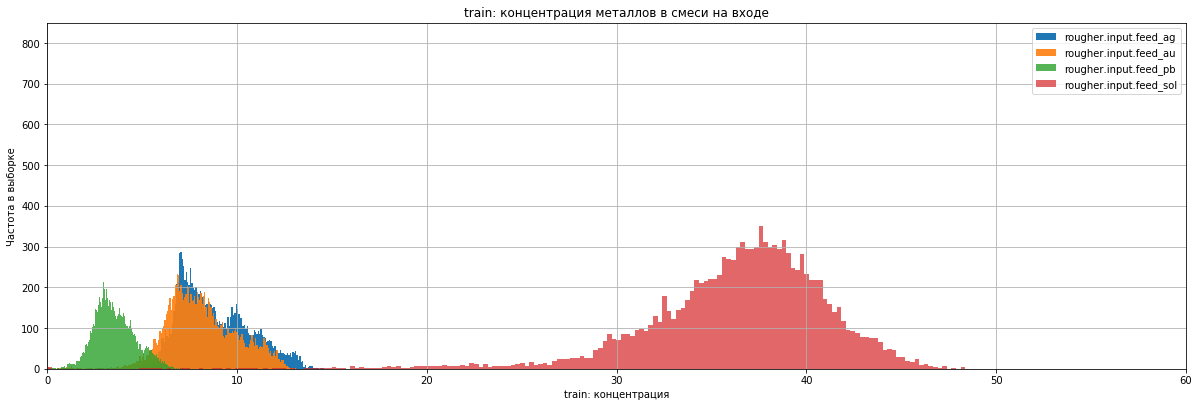

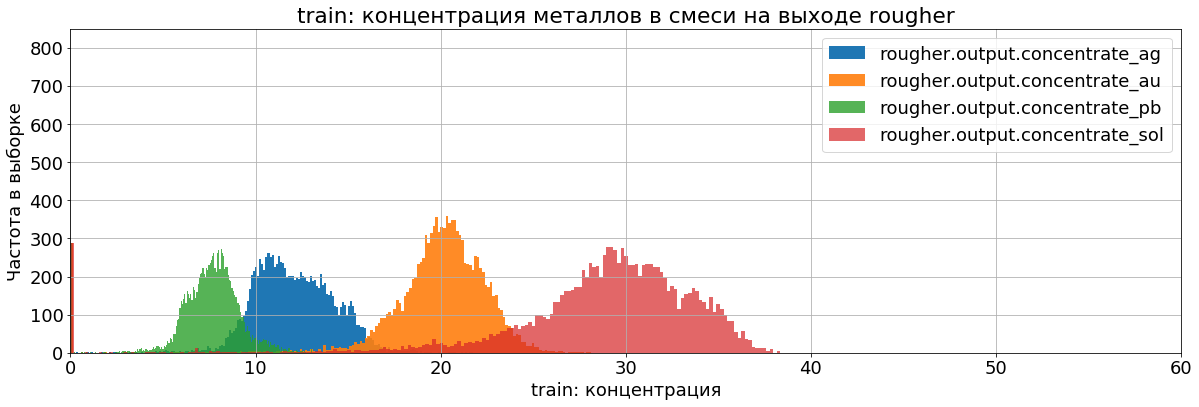

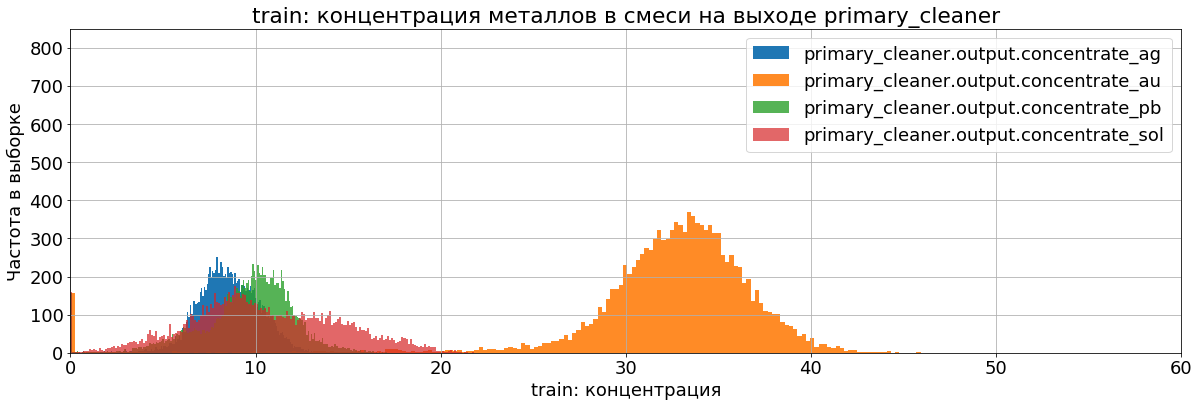

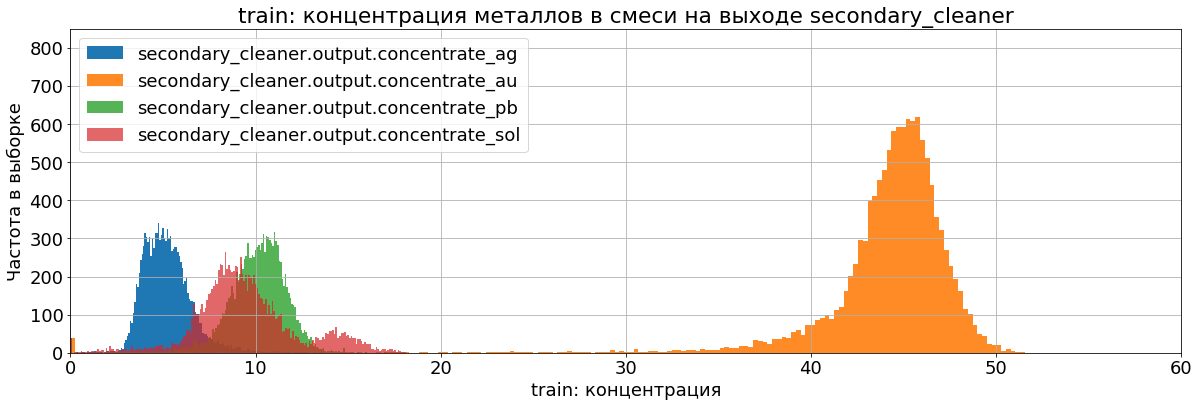

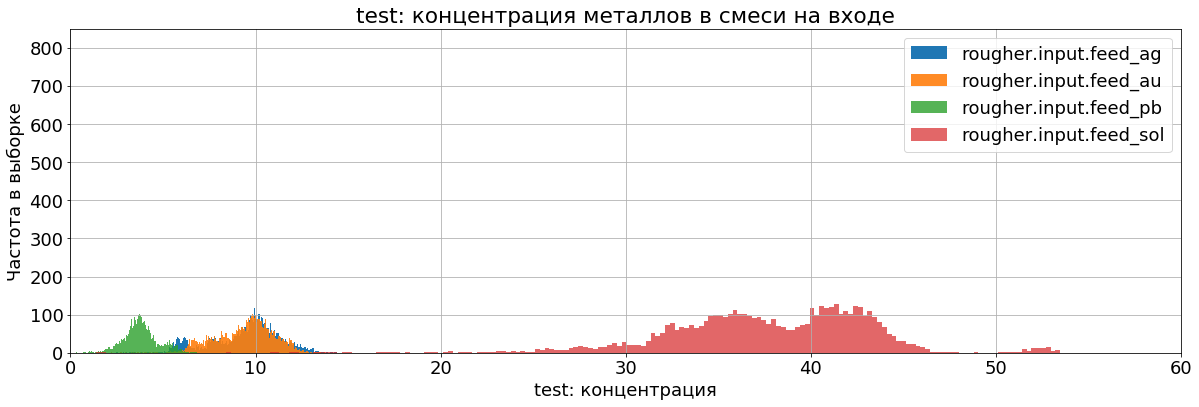

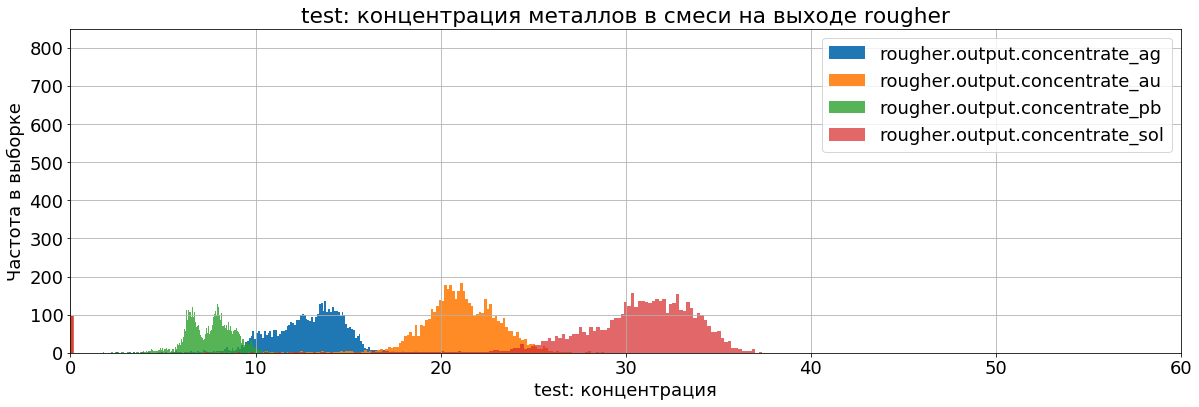

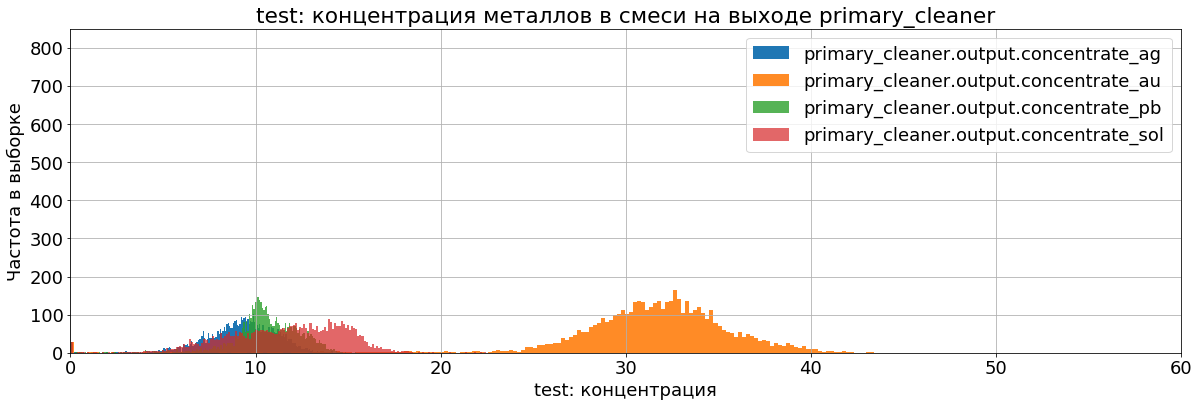

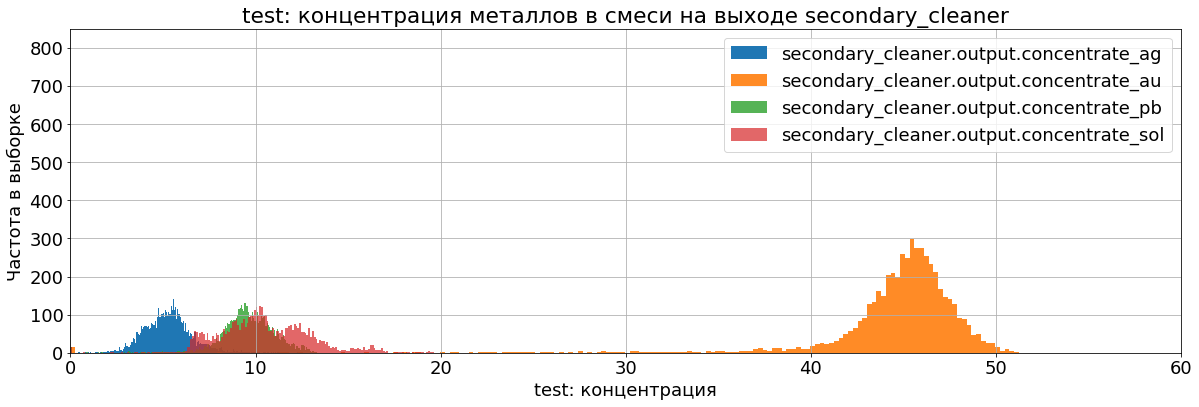

In [39]:
for set in ['train','test']:
    hist(
        onecolumn_frames_list = [
            data.df(set=set, stage='rougher', type='input', param='feed_ag'),
            data.df(set=set, stage='rougher', type='input', param='feed_au'),
            data.df(set=set, stage='rougher', type='input', param='feed_pb'),
            data.df(set=set, stage='rougher', type='input', param='feed_sol'),
        ],
        xlab=f'{set}: концентрация',
        ylab='Частота в выборке',
        title=f'{set}: концентрация металлов в смеси на входе',
        fontsize=18,
        xrange=(0,60), 
        yrange=(0,850),
        bins=200,
        figsize=(17,6)
    )
    for stage in ['rougher','primary_cleaner','secondary_cleaner']:
        hist(
            onecolumn_frames_list = [
                data.df(set=set, stage=stage, type='output', param='concentrate_ag'),
                data.df(set=set, stage=stage, type='output', param='concentrate_au'),
                data.df(set=set, stage=stage, type='output', param='concentrate_pb'),
                data.df(set=set, stage=stage, type='output', param='concentrate_sol'),
            ],
            xlab=f'{set}: концентрация',
            ylab='Частота в выборке',
            title=f'{set}: концентрация металлов в смеси на выходе {stage}',
            fontsize=18,
            xrange=(0,60), 
            yrange=(0,850),        
            bins=200,
            figsize=(17,6)
        )

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Графики построены корректно 👍
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера:</b> 

~~На всех графиках задай одинаковые диапазоны изменения осей, чтобы сравнивать распределения между собой было удобнее. ~~
    
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Скорректировал


Что с концентрацией золота в хвостах на всех этапах для train и test? mean растет, но, ожидаемо медленно (+есть выбросы):

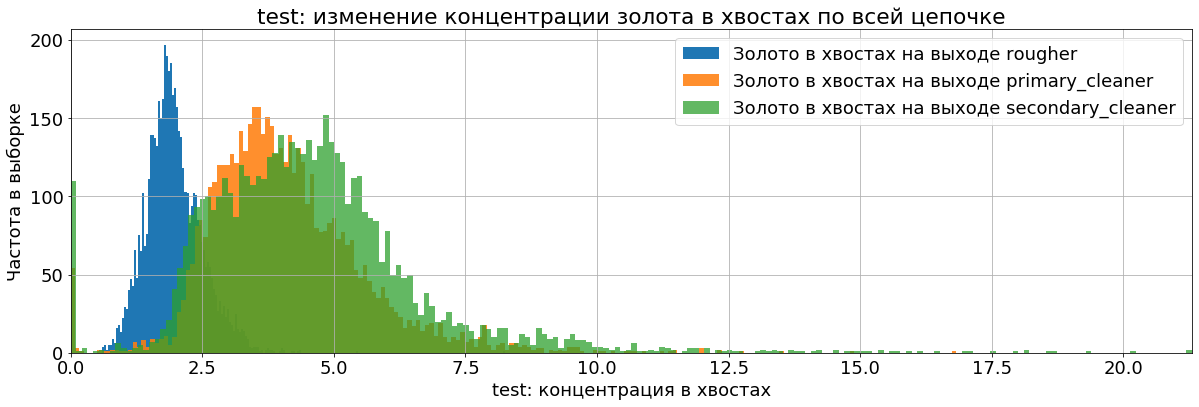

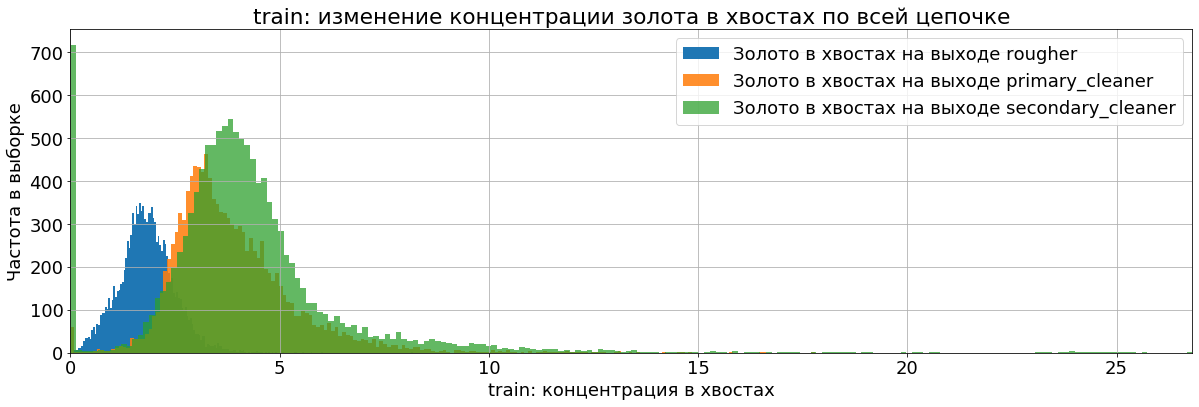

In [40]:
for set in ['test', 'train']:
    hist(
        onecolumn_frames_list = [
            pd.DataFrame({"Золото в хвостах на выходе rougher": data.df(set=set)['rougher.output.tail_au']}),
            pd.DataFrame({"Золото в хвостах на выходе primary_cleaner": data.df(set=set)['primary_cleaner.output.tail_au']}),
            pd.DataFrame({"Золото в хвостах на выходе secondary_cleaner": data.df(set=set)['secondary_cleaner.output.tail_au']}),
        ],
        xlab=f'{set}: концентрация в хвостах',
        ylab='Частота в выборке',
        title=f'{set}: изменение концентрации золота в хвостах по всей цепочке',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )


Ключевой вывод: процесс достигает своей цели, т.к. концентрация золота растет от этапа к этапу

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Правильно, концентрация золота растет от этапа к этапу.
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 

~~Как меняются концентрации остальных металлов по мере прохождения технологического процесса?~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Тут я не понял твоего замечания. На графиках <b>изначально</b> все видно. Может быть тебя интересует формальный вывод? 
  Хорошо, он звучит так: 
    
<b>concetrate_ag: падает на выходе каждого этапа, кроме rougher, где немного возрастает по сравнению с изначальной</b>

<b>concentrate_pb: растет на выходе каждого этапа</b>

<b>concentrate_sol: (это не металл, скорее, какой-то реагент): падает на выходе каждого этапа</b>
    
    
    

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
Да, спасибо, хотелось увидеть именно такой вывод.
</div>

Также, для входной смеси есть большое количество близих к нулю значений, которые "тянут" наши распределения влево на последующих этапах. Посмотрим на них повнимательнее:

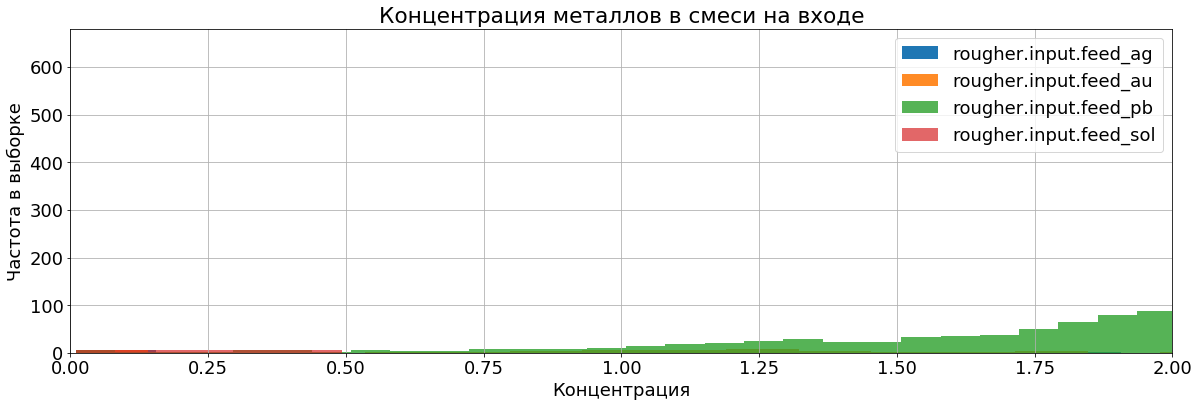

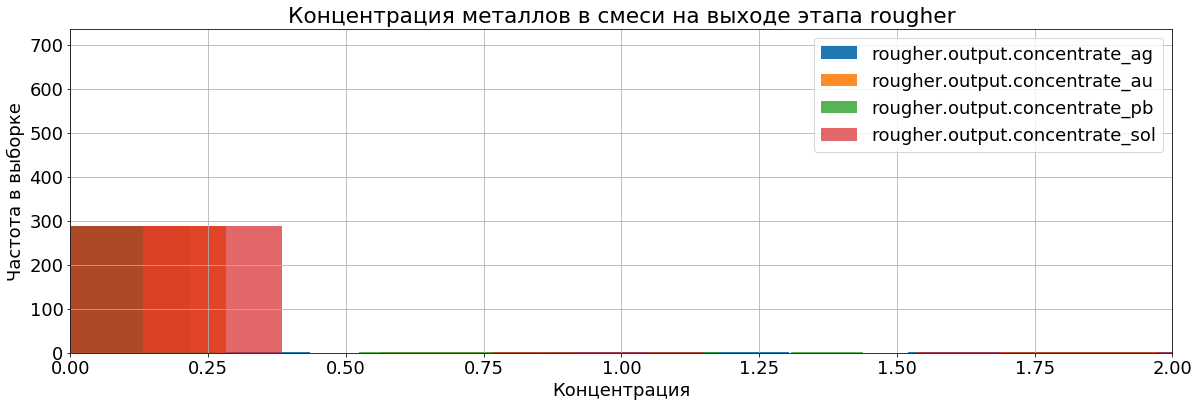

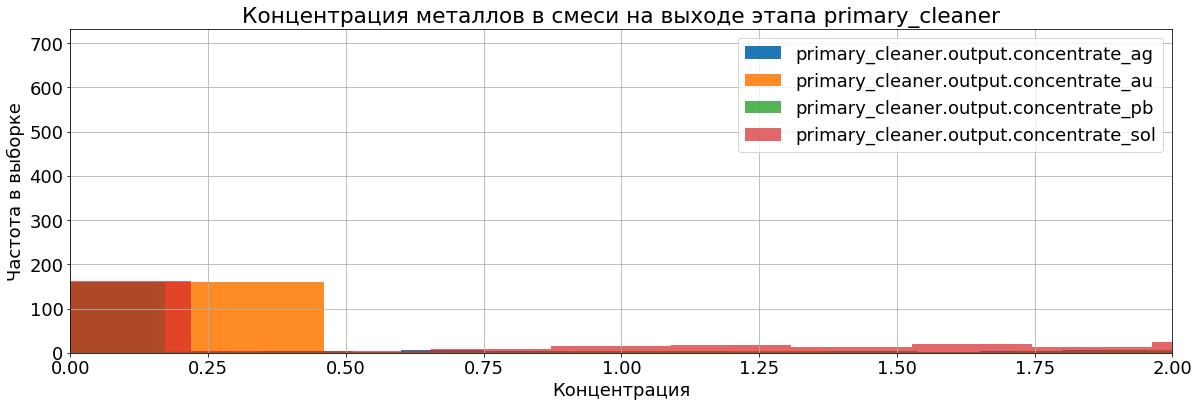

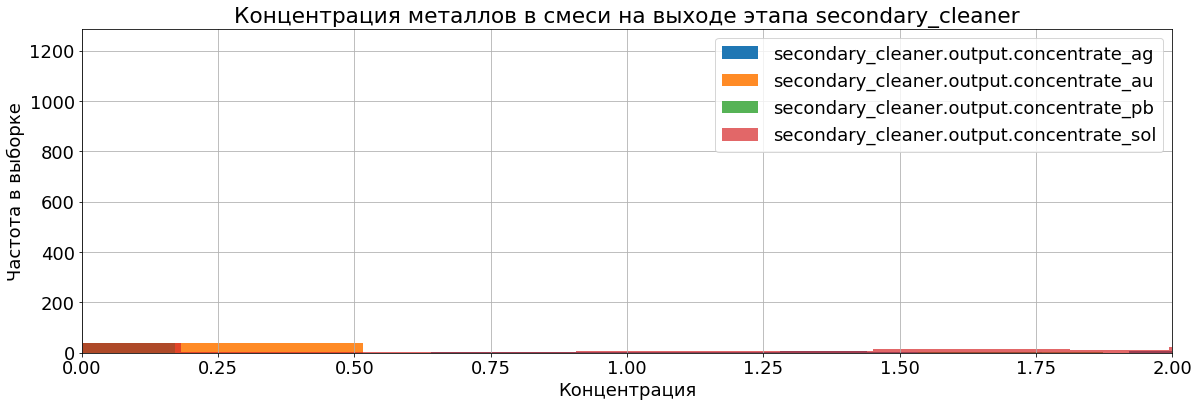

In [41]:
hist(
        onecolumn_frames_list = [
            data.df(set='train', stage='rougher', type='input', param='feed_ag'),
            data.df(set='train', stage='rougher', type='input', param='feed_au'),
            data.df(set='train', stage='rougher', type='input', param='feed_pb'),
            data.df(set='train', stage='rougher', type='input', param='feed_sol')
        ],
        xlab='Концентрация',
        ylab='Частота в выборке',
        title=f'Концентрация металлов в смеси на входе',
        fontsize=18,
        xrange=(0,2), 
        bins=100,
        figsize=(17,6)
)
for stage in ['rougher','primary_cleaner','secondary_cleaner']:
    hist(
        onecolumn_frames_list = [
            data.df(set='train', stage=stage, type='output', param='concentrate_ag'),
            data.df(set='train', stage=stage, type='output', param='concentrate_au'),
            data.df(set='train', stage=stage, type='output', param='concentrate_pb'),
            data.df(set='train', stage=stage, type='output', param='concentrate_sol')
        ],
        xlab='Концентрация',
        ylab='Частота в выборке',
        title=f'Концентрация металлов в смеси на выходе этапа {stage}',
        fontsize=18,
        xrange=(0,2), 
        bins=100,
        figsize=(17,6)
    )
    

Сырье с низким содержанием металлов (а также субстанции "sol") дает соответствующий результат: Garbage In - Garbage Out. Характер изменение уровня концентрации золота явно не соответствуют тому, что наблюдается для более богатой смеси, из чего можно заключить, что для сырья с низкой концентрацией действует своя зависимость между входами и выходами (при прочих равных). Для нашей модели это будет "фактором ошибки" (она просто "будет пытаться предсказать иную зависимость"), поэтому, выкинем без сожаления:

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Околонулевые концентрации, действительно, являются аномальными. Скорее всего, они связаны со сбоями измерительного оборудования.
</div>

In [42]:
prefixes = [
        'rougher.input.feed_',
        'rougher.output.concentrate_',
        'primary_cleaner.output.concentrate_',
        'secondary_cleaner.output.concentrate_',

        'rougher.input.feed_',
        'rougher.output.concentrate_',
        'primary_cleaner.output.concentrate_',
        'secondary_cleaner.output.concentrate_'
    
]
cleanup_list = []
for prefix in prefixes:
    for metall in ['au','ag','pb','sol']:
        cleanup_list.append(prefix + metall)
    
for set in ['test', 'train']:
    rdf = data.df(set=set, inc_date=True).copy()
    for feat in cleanup_list:
        rdf = rdf[rdf[feat] > 1]
    data.update_set(set, rdf.reset_index(drop=True))

Теперь, по сумме металлов убедимся, что "проблема ушла после коррекции входных данных":

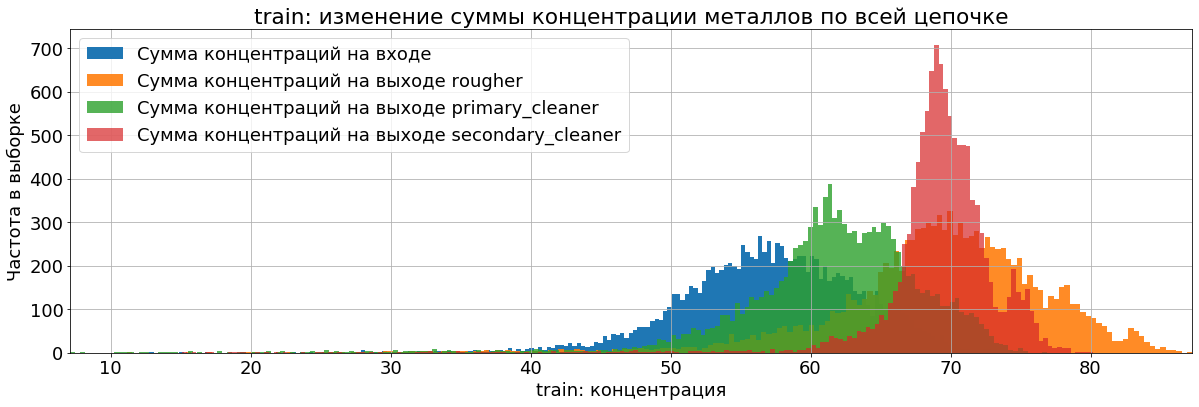

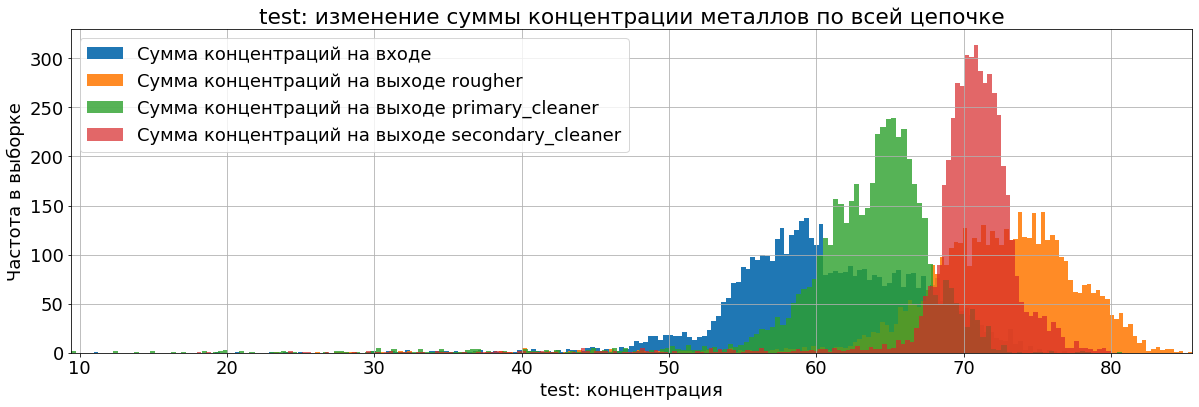

In [43]:
for set in ['train','test']:
    hist(
        onecolumn_frames_list = [
            pd.DataFrame({"Сумма концентраций на входе":
                data.df(set=set)['rougher.input.feed_ag']
                + data.df(set=set)['rougher.input.feed_au']
                + data.df(set=set)['rougher.input.feed_pb']
                + data.df(set=set)['rougher.input.feed_sol']
            }),            
            pd.DataFrame({"Сумма концентраций на выходе rougher":
                data.df(set=set)['rougher.output.concentrate_ag']
                + data.df(set=set)['rougher.output.concentrate_au']
                + data.df(set=set)['rougher.output.concentrate_pb']                          
                + data.df(set=set)['rougher.output.concentrate_sol']                          
            }),
            pd.DataFrame({"Сумма концентраций на выходе primary_cleaner":
                data.df(set=set)['primary_cleaner.output.concentrate_ag']
                + data.df(set=set)['primary_cleaner.output.concentrate_au']
                + data.df(set=set)['primary_cleaner.output.concentrate_pb']
                + data.df(set=set)['primary_cleaner.output.concentrate_sol']
            }),
            pd.DataFrame({"Сумма концентраций на выходе secondary_cleaner":
                data.df(set=set)['secondary_cleaner.output.concentrate_ag']
                + data.df(set=set)['secondary_cleaner.output.concentrate_au']
                + data.df(set=set)['secondary_cleaner.output.concentrate_pb']
                + data.df(set=set)['secondary_cleaner.output.concentrate_sol']
            }),  
        ],
        xlab=f'{set}: концентрация',
        ylab='Частота в выборке',
        title=f'{set}: изменение суммы концентрации металлов по всей цепочке',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Графики отличные.
</div>

Отметим, что в случае с "хвостами" такой подход использовать нельзя: любые "аномалии хвостов" - следствие физических процессов (<b>хотя ими могут быть и сбои датчиков, замеряющих уровни</b>), а не "особых случаев входных данных":

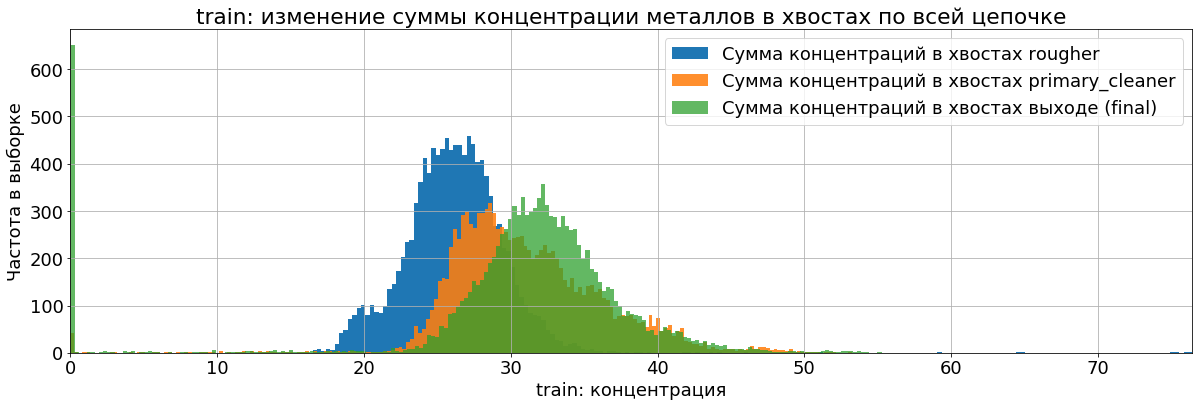

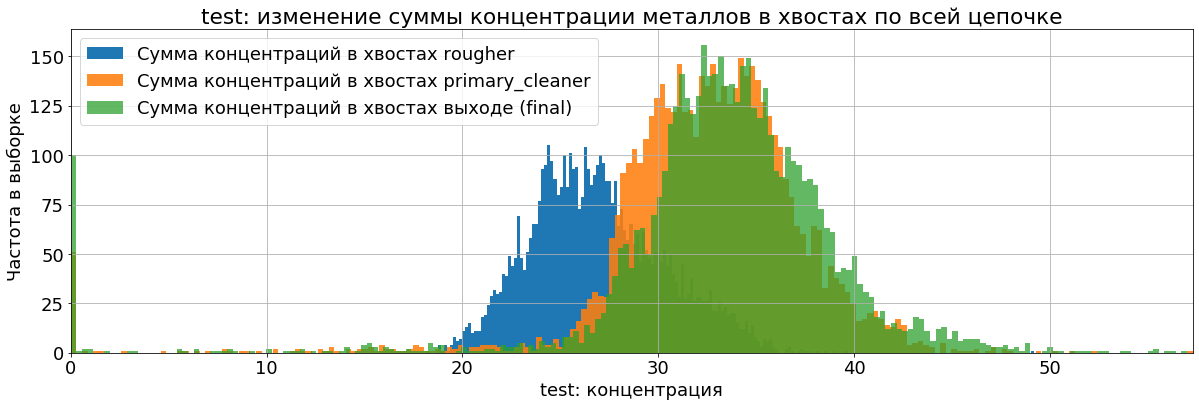

In [44]:
for set in ['train','test']:
    hist(
        onecolumn_frames_list = [            
            pd.DataFrame({"Сумма концентраций в хвостах rougher":
                data.df(set=set)['rougher.output.tail_ag']
                + data.df(set=set)['rougher.output.tail_au']
                + data.df(set=set)['rougher.output.tail_pb']
                + data.df(set=set)['rougher.output.tail_sol']
            }),            
            pd.DataFrame({"Сумма концентраций в хвостах primary_cleaner":
                data.df(set=set)['primary_cleaner.output.tail_ag']
                + data.df(set=set)['primary_cleaner.output.tail_au']
                + data.df(set=set)['primary_cleaner.output.tail_pb']
                + data.df(set=set)['primary_cleaner.output.tail_sol']
            }),
            pd.DataFrame({"Сумма концентраций в хвостах выходе (final)":
                data.df(set=set)['secondary_cleaner.output.tail_ag']
                + data.df(set=set)['secondary_cleaner.output.tail_au']
                + data.df(set=set)['secondary_cleaner.output.tail_pb']
                + data.df(set=set)['secondary_cleaner.output.tail_sol']
            }),              
        ],
        xlab=f'{set}: концентрация',
        ylab='Частота в выборке',
        title=f'{set}: изменение суммы концентрации металлов в хвостах по всей цепочке',
        fontsize=18,
        bins=200,
        figsize=(17,6)
    )

Что с распределениями размеров гранул сырья для train и test? Формально, ничего хорошего:

In [45]:
ttest(
    data.df(set='train')['rougher.input.feed_size'],
    'размер сырья для train-выборки',
    data.df(set='test')['rougher.input.feed_size'],
    'размер сырья для test-выборки',
)

Подготовка теста: используем equal_vars = True, т.к.
   var(размер сырья для train-выборки) = 425.53030578889087
   var(размер сырья для test-выборки) = 223.43084142635314
Результат теста: отвергаем нулевую гипотезу, т.к. 1.877695120000779e-28 < 0.01


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
По результатам наших недавних дискуссий, было решено, что при проведении ttest-а сравнивать выборочные дисперсии выборок не требуется, можно всегда использовать тест Уэлша (equal_var=False). Условие на равенство дисперсий работает для классического t-теста (нормальные исходные данные, малые выборки), но на практике мы сравниваем обычно не-нормальные исходные данные в больших выборках, у них равенство дисперсий едва ли будет наблюдаться.
</div>

Но это - нормально, ведь проблема в распределениях: они "хвостатые" и train аж "двуэкстремумное", так что t-test нерепрезентативен:

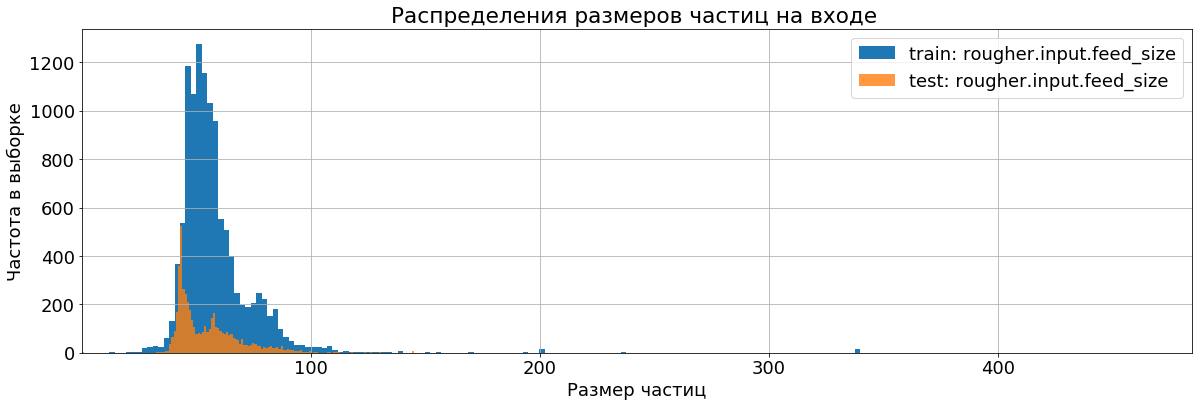

In [46]:
hist(
        onecolumn_frames_list = [
            data.df(set='train', stage='rougher', type='input', param='feed_size')\
                .rename(columns={'rougher.input.feed_size': 'train: rougher.input.feed_size'}),
            data.df(set='test', stage='rougher', type='input', param='feed_size')\
                .rename(columns={'rougher.input.feed_size': 'test: rougher.input.feed_size'}),
        ],
        xlab='Размер частиц',
        ylab='Частота в выборке',
        title=f'Распределения размеров частиц на входе ',
        fontsize=18,
        bins=200,
        figsize=(17,6)
)

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~Так как число объектов в обучающей и тестовой выборках отличается, то вместо гистограмм **частот** стоит сравнивать гистограммы **плотностей распределений**.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ok, вот distplot:

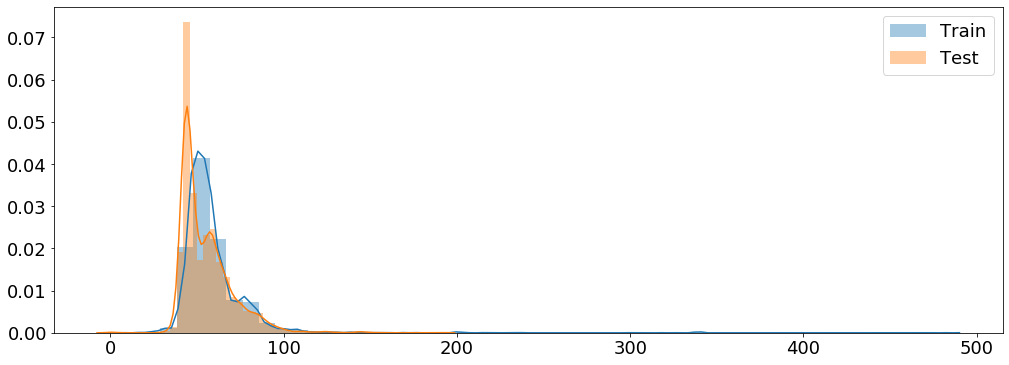

In [47]:
fig = plt.figure(figsize=(17,6))
sns.distplot(data.df(set='train', stage='rougher', type='input', param='feed_size'))
sns.distplot(data.df(set='test', stage='rougher', type='input', param='feed_size'))
plt.legend(labels=['Train','Test'])
plt.show()

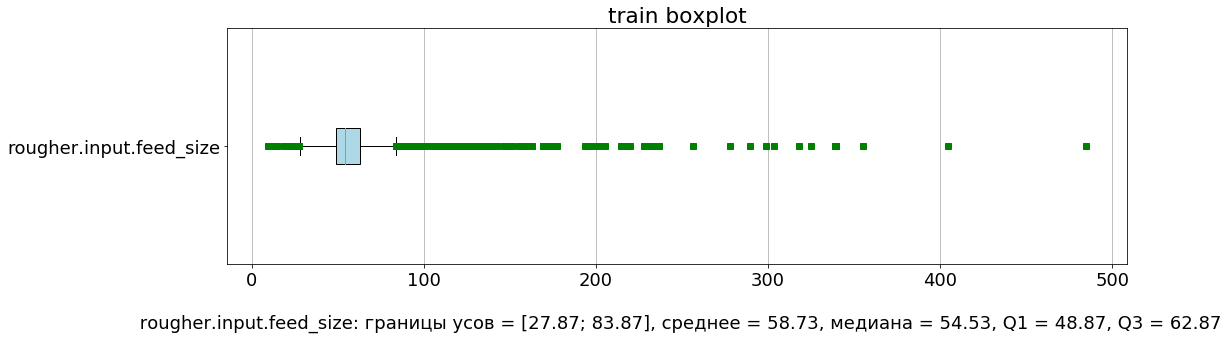

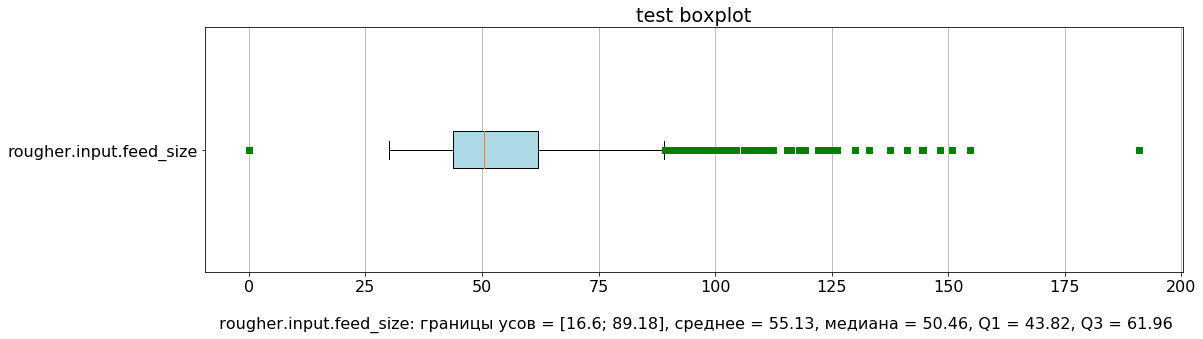

In [48]:
boxplot(
        [
            data.df(set='train')[['rougher.input.feed_size']],
        ],
        figsize=(17,5), 
        fontsize=16,
        title='train boxplot'
) 
boxplot(
        [
            data.df(set='test')[['rougher.input.feed_size']],
        ],
        figsize=(17,5), 
        fontsize=16,
        title='test boxplot'
) 

Поэтому просто удовлетворимся текущим положением дел (и даже не будем "обрезать выбросы по границам усов"):

In [49]:
display_side_by_side(
    data.df(set='train', stage='rougher', type='input', param='feed_size').describe(),
    data.df(set='test', stage='rougher', type='input', param='feed_size').describe(),  
    titles=['Train','Test']
)

,rougher.input.feed_size
count,11518.000000
mean,58.731342
std,20.628386
min,9.659576
25%,48.871136
50%,54.530392
75%,62.868985
max,484.967466
,rougher.input.feed_size
count,4954.000000


<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Считаем, что значительных отличий между распределениями нет.
</div>

В качестве завершающего аккорда, посмотрим на изменение концентрации золота по этапам для train:

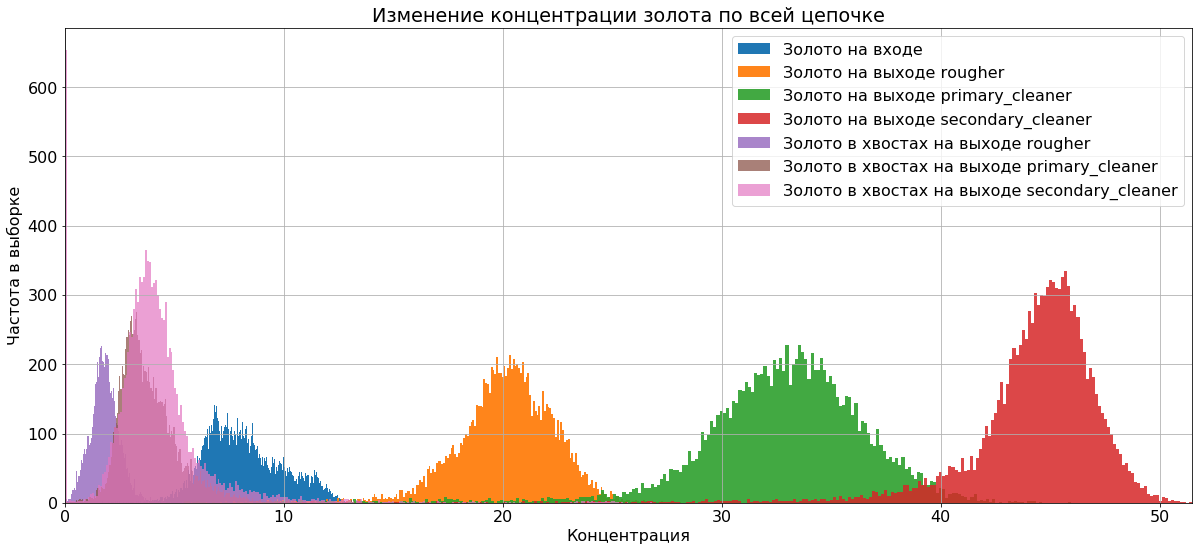

In [50]:
hist(
        onecolumn_frames_list = [
            pd.DataFrame({"Золото на входе": data.df(set='train')['rougher.input.feed_au']}),
            pd.DataFrame({"Золото на выходе rougher": data.df(set='train')['rougher.output.concentrate_au']}),
            pd.DataFrame({"Золото на выходе primary_cleaner": data.df(set='train')['primary_cleaner.output.concentrate_au']}),
            pd.DataFrame({"Золото на выходе secondary_cleaner": data.df(set='train')['secondary_cleaner.output.concentrate_au']}),
            pd.DataFrame({"Золото в хвостах на выходе rougher": data.df(set='train')['rougher.output.tail_au']}),
            pd.DataFrame({"Золото в хвостах на выходе primary_cleaner": data.df(set='train')['primary_cleaner.output.tail_au']}),
            pd.DataFrame({"Золото в хвостах на выходе secondary_cleaner": data.df(set='train')['secondary_cleaner.output.tail_au']})
        ],
        xlab='Концентрация',
        ylab='Частота в выборке',
        title=f'Изменение концентрации золота по всей цепочке',
        fontsize=18,
        bins=300,
        figsize=(17,8)
)

Горы золота! Богатеем не по дням, а по часам, в строгом соответствии с заветами Крёза и Мидаса (... или Ольги Бузовой?)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
👍
</div>

## Модель

Выполним показательный прогон по трем классам моделей для rougher->concentrate/tail (~2x4=8 мин.): DT(GBDT), KNN и четыре линейных модели:  

In [51]:
reports = { }
for target in ['concentrate_au','tail_au']:
    feat_train = data.df(set='train', stage='rougher',type='state|input')
    targ_train = data.df(set='train')[f'rougher.output.{target}']
    feat_test = data.df(set='test', stage='rougher',type='state|input')
    targ_test = data.df(set='test')[f'rougher.output.{target}']
    stage = StageClass(name='rougher', target=target)
    stage.process(feat_train, targ_train, feat_test, targ_test)
    frame = stage.report().sort_values(by=['CV-sMAPE (train)'])
    reports[target] = frame 

Выбор гиперпараметров GradientBoostingRegressor для предсказания concentrate_au занял 27.945 секунд
Выбор гиперпараметров KNeighborsRegressor для предсказания concentrate_au занял 53.566 секунд
Выбор гиперпараметров ElasticNet для предсказания concentrate_au занял 2.605 секунд
Выбор гиперпараметров LinearRegression для предсказания concentrate_au занял 0.594 секунд
Выбор гиперпараметров HuberRegressor для предсказания concentrate_au занял 16.783 секунд
Выбор гиперпараметров PassiveAggressiveRegressor для предсказания concentrate_au занял 6.952 секунд
Выбор гиперпараметров SGDRegressor для предсказания concentrate_au занял 26.451 секунд
Общее время 142.72520430386066
Выбор гиперпараметров GradientBoostingRegressor для предсказания tail_au занял 23.377 секунд
Выбор гиперпараметров KNeighborsRegressor для предсказания tail_au занял 54.697 секунд
Выбор гиперпараметров ElasticNet для предсказания tail_au занял 2.506 секунд
Выбор гиперпараметров LinearRegression для предсказания tail_au заня

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
Альтернативный вариант – сразу предсказывать целевые признаки rougher.output.recovery и final.output.recovery.
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> я очень скептически отношусь к предсказанию расчетных признаков. Какой смысл предсказывать то, что мы можем посчитать?

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
Заранее нельзя сказать, какой способ даст лучшее итоговое качество. 
</div>

In [52]:
reports['concentrate_au']

,стадия,target,estimator,лучшие параметры,CV-sMAPE (train),sMAPE (вся train),sMAPE (test)
6,rougher,concentrate_au,SGDRegressor,"{'loss': 'squared_loss', 'penalty': 'elasticnet', 'power_t': 0.1}",0.074649,0.066155,0.067095
4,rougher,concentrate_au,HuberRegressor,"{'epsilon': 1.0, 'fit_intercept': True, 'max_iter': 80}",0.074830,0.064602,0.067845
0,rougher,concentrate_au,GradientBoostingRegressor,"{'max_depth': 5, 'n_estimators': 43, 'random_state': 12345}",0.075283,0.045114,0.081101
3,rougher,concentrate_au,LinearRegression,"{'fit_intercept': True, 'normalize': True}",0.075969,0.066584,0.068428
1,rougher,concentrate_au,KNeighborsRegressor,{'n_neighbors': 317},0.084517,0.059776,0.077207
2,rougher,concentrate_au,ElasticNet,"{'alpha': 0.8, 'fit_intercept': True, 'normalize': False}",0.091322,0.081849,0.082933
5,rougher,concentrate_au,PassiveAggressiveRegressor,"{'C': 1, 'max_iter': 100, 'random_state': 12345}",0.110983,0.084431,0.093399


In [53]:
reports['tail_au']

,стадия,target,estimator,лучшие параметры,CV-sMAPE (train),sMAPE (вся train),sMAPE (test)
6,rougher,tail_au,SGDRegressor,"{'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'power_t': 0.1}",0.280331,0.229289,0.203540
4,rougher,tail_au,HuberRegressor,"{'epsilon': 2.0, 'fit_intercept': True, 'max_iter': 80}",0.284533,0.226089,0.195339
3,rougher,tail_au,LinearRegression,"{'fit_intercept': True, 'normalize': True}",0.288178,0.226235,0.196071
0,rougher,tail_au,GradientBoostingRegressor,"{'max_depth': 3, 'n_estimators': 11, 'random_state': 12345}",0.295463,0.228414,0.180374
2,rougher,tail_au,ElasticNet,"{'alpha': 0.8, 'fit_intercept': True, 'normalize': True}",0.312618,0.292672,0.207609
1,rougher,tail_au,KNeighborsRegressor,{'n_neighbors': 317},0.321946,0.203543,0.187198
5,rougher,tail_au,PassiveAggressiveRegressor,"{'C': 1, 'max_iter': 100, 'random_state': 12345}",0.413221,0.358680,0.338751


Линейные модели в нашем случае побеждают и показывают примерно схожий результат. Сделаем несоклько ремарок о дополнительных гипотезах:
1. Возможно, на разных этапах вполне могут победить разные модели (изменить код несложно, но время - глубокая ночь и хочется спать)
2. Возможно, у входных state-данных этапов есть внутренние зависимости (например, коцентрация "присадок" может меняться со временем)

В рамках данной работы мы не будем проверять эти гипотезы - займет время (дедлайн поджимает), да и технологической карты/детального описания процесса у нас все равно нет - можно гадать сколько угодно "почему именно так" и все равно ошибиться. В целом, определяющим фактором является целеполагание - мы, все же "учимся в условиях, близких к реальным", а не решаем бизнес-задачу.

Теперь, возьмем лучшую модель (по результатам CV) и, оставив активной только ее (+игнорируя неэффективность повторного обучения, это не критично для нашей цели), пройдемся по всем трем стадиям,при этом:
1. Предсказанные выходы золота из стадии rougher **станут** входными данными для test primary_cleaner (их не было в test)
2. Предсказанные выходы золота из стадии primary_cleaner **станут** входными данными для test secondary_cleaner (их не было в test)
3. Остальные выходы заполним из восстановленых данных по full (проще, чем проходиться по всем компонентам)

In [54]:
best_estimators = {}
for target in ['concentrate_au','tail_au']:
    best_estimators[target] = reports[target].iloc[0,2]
    print('Для предсказания', target,'используем', best_estimators[target], 'в StageClass')

Для предсказания concentrate_au используем SGDRegressor в StageClass
Для предсказания tail_au используем SGDRegressor в StageClass


In [55]:
stages_data = {} # свод данных по результатам работы

Стадия rougher:

In [56]:
feat_train = data.df(set='train', stage='rougher',type='state|input')
feat_test = data.df(set='test', stage='rougher',type='state|input')
stages_data['rougher'] = process_stage('rougher', best_estimators, feat_train, feat_test)
stages_data['rougher']['report']

Выбор гиперпараметров SGDRegressor для предсказания concentrate_au занял 26.338 секунд
Общее время 26.36372574046254
Выбор гиперпараметров SGDRegressor для предсказания tail_au занял 6.551 секунд
Общее время 6.75499314814806


,стадия,target,estimator,лучшие параметры,CV-sMAPE (train),sMAPE (вся train),sMAPE (test)
0,rougher,concentrate_au,SGDRegressor,"{'loss': 'epsilon_insensitive', 'penalty': 'elasticnet', 'power_t': 0.1}",0.073778,0.065147,0.068637
0,rougher,tail_au,SGDRegressor,"{'loss': 'squared_epsilon_insensitive', 'penalty': 'l2', 'power_t': 0.1}",0.281937,0.236843,0.211289


Стадия primary_cleaner (для test добавляем в качестве входных данных выходы золота, предсказанные для rougher):

In [57]:
feat_train = pd.concat(
        [
            data.df(set='train', stage='rougher', type='output', param='concentrate'),
            data.df(set='train', stage='primary_cleaner',type='state|input')
        ],
        axis='columns')

feat_test_resurrected = data.df(set='test', stage='rougher', type='output', param='concentrate').copy()
feat_test_resurrected['rougher.output.concentrate_au'] = stages_data['rougher']['concentrate_au']['pred_test']

feat_test = pd.concat(
        [
            feat_test_resurrected,
            data.df(set='test', stage='primary_cleaner',type='state|input')
        ],
        axis='columns')

stages_data['primary_cleaner'] = process_stage('primary_cleaner', best_estimators, feat_train, feat_test)
stages_data['primary_cleaner']['report']


Выбор гиперпараметров SGDRegressor для предсказания concentrate_au занял 41.926 секунд
Общее время 41.95105895027518
Выбор гиперпараметров SGDRegressor для предсказания tail_au занял 7.891 секунд
Общее время 8.094996880739927


,стадия,target,estimator,лучшие параметры,CV-sMAPE (train),sMAPE (вся train),sMAPE (test)
0,primary_cleaner,concentrate_au,SGDRegressor,"{'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'power_t': 0.1}",0.076870,0.076241,0.098397
0,primary_cleaner,tail_au,SGDRegressor,"{'loss': 'squared_loss', 'penalty': 'l2', 'power_t': 0.1}",0.271626,0.237827,0.361445


Стадия secondary_cleaner (добавляем в качестве входных данных предсказанные значения выходов primary_cleaner по золоту):

In [58]:
feat_train = pd.concat(
        [
            data.df(set='train', stage='primary_cleaner', type='output', param='concentrate'),
            data.df(set='train', stage='secondary_cleaner',type='state|input')
        ],
        axis='columns')

feat_test_resurrected = data.df(set='test', stage='primary_cleaner', type='output', param='concentrate').copy()
feat_test_resurrected['primary_cleaner.output.concentrate_au'] = stages_data['primary_cleaner']['concentrate_au']['pred_test']

feat_test = pd.concat(
        [
            feat_test_resurrected,
            data.df(set='test', stage='secondary_cleaner',type='state|input')
        ],
        axis='columns')

stages_data['secondary_cleaner'] = process_stage('secondary_cleaner', best_estimators, feat_train, feat_test)
stages_data['secondary_cleaner']['report']



Выбор гиперпараметров SGDRegressor для предсказания concentrate_au занял 62.462 секунд
Общее время 62.49020175635815
Выбор гиперпараметров SGDRegressor для предсказания tail_au занял 10.791 секунд
Общее время 10.81827636808157


,стадия,target,estimator,лучшие параметры,CV-sMAPE (train),sMAPE (вся train),sMAPE (test)
0,secondary_cleaner,concentrate_au,SGDRegressor,"{'loss': 'squared_epsilon_insensitive', 'penalty': 'l1', 'power_t': 0.1}",0.046071,0.040498,0.065685
0,secondary_cleaner,tail_au,SGDRegressor,"{'loss': 'epsilon_insensitive', 'penalty': 'l2', 'power_t': 0.1}",0.427459,0.350287,0.339255


Рассчитаем итоговое sMAPE для test:

In [59]:
recovery_rougher_orig = calculate_recovery(
        data.df(set='test')['rougher.output.concentrate_au'],        
        data.df(set='test')['rougher.input.feed_au'],
        data.df(set='test')['rougher.output.tail_au']        
    )

recovery_rougher_pred = calculate_recovery(
        stages_data['rougher']['concentrate_au']['pred_test'],
        data.df(set='test')['rougher.input.feed_au'],
        stages_data['rougher']['tail_au']['pred_test']        
    )

smape_recovery_rougher = StageClass.smape_error(recovery_rougher_orig, recovery_rougher_pred)

In [60]:
recovery_secondary_cleaner_orig = calculate_recovery(
        data.df(set='test')['secondary_cleaner.output.concentrate_au'],        
        data.df(set='test')['primary_cleaner.output.concentrate_au'], 
        data.df(set='test')['secondary_cleaner.output.tail_au']        
    )

recovery_secondary_cleaner_pred = calculate_recovery(
        stages_data['secondary_cleaner']['concentrate_au']['pred_test'],
        # data.df(set='test')['primary_cleaner.output.concentrate_au'], 
        stages_data['primary_cleaner']['concentrate_au']['pred_test'], 
        stages_data['secondary_cleaner']['tail_au']['pred_test']        
    )

smape_recovery_secondary_cleaner = StageClass.smape_error(recovery_secondary_cleaner_orig, recovery_secondary_cleaner_pred)

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~Проверь формулу для расчета эффективности final.output.recovery (в твоей нотации – secondary_cleaner.output.recovery): вместо primary_cleaner.output.concentrate_au должен быть другой признак.~~
    
~~Также замечу, что мы можем использовать только те столбцы, которые были в исходной тестовой выборке (/datasets/gold_recovery_test.csv), остальные нам недоступны.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Согласен, поправил. По второй части твоего вопроса отмечу лишь, что формально условия не нарушены: я могу использовать full, раз он мне доступен как "данные условий задачи". Неформально, вопрос только в том, каков путь решения: авторы задачи считают, что надо предсказывать расчетный признак, мне подобная позиция не кажется правильной (правильно с моей точки зрения: расчетный признак надо рассчитывать на основании предсказаний его составляющих)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
Ок, принято.
</div>

In [61]:
print('smape recovery этапа rougher:', smape_recovery_rougher)
print('smape recovery этапа secondary_cleaner:', smape_recovery_secondary_cleaner)
print('итоговое smape: ', 0.25 * smape_recovery_rougher + 0.75 * smape_recovery_secondary_cleaner)


smape recovery этапа rougher: 0.039551710705517315
smape recovery этапа secondary_cleaner: 0.02726964817176441
итоговое smape:  0.030340163805202634


Значение прямо-таки экстремально низкое, но, предполагаю, это связано с предсказанием лишь одного компонента из четырех (ag, pb и sol брались из восстановленных данных) для primary/secondary cleaner 

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
~~Добавь проверку итоговой модели на адекватность: сравни ее качество с качеством константной модели, предсказывающей среднее/медианное значение целевых признаков для всех объектов тестовой выборки. Обращаю внимание, что среднее/медианное значение должно вычисляться по обучающей выборке.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> Да, вот тут действительно интересно. Давай посмотрим на "невзлет и падение адекватности" по разным стадиям:

In [62]:
def adeq_comparation(stage: str, type: str, function) -> None:
    fname = f'{function}'.split(' ')[1]
    frame = pd.DataFrame({'stage': [], 'type':[], 'target':[], 'значения':[], f'{fname}':[]})
    for target in ['concentrate_au','tail_au']:
        target_train_true = data.df(set='train')[f'{stage}.{type}.{target}']
        target_mean = target_train_true.mean()
        target_median = target_train_true.median() 
    
        target_true = data.df(set='test')[f'{stage}.{type}.{target}']
        target_pred = stages_data[f'{stage}'][target]['pred_test']
        size = target_pred.count()
        index = target_pred.index

        target_pred_mean_dummy = pd.Series(data=np.full(size, target_mean), index=index)
        target_pred_median_dummy = pd.Series(data=np.full(size, target_median), index=index)
        
        frame.loc[len(frame)] = [stage, type, target, 'dummy mean', function(target_true, target_pred_mean_dummy)]
        frame.loc[len(frame)] = [stage, type, target, 'dummy median', function(target_true, target_pred_median_dummy)]
        frame.loc[len(frame)] = [stage, type, target, 'predicted', function(target_true, target_pred)]
    return frame    

rougher: значения R2 уже ничтожно, но хотя бы положительно для concentrate_au

In [63]:
adeq_comparation('rougher','output', r2_score)

,stage,type,target,значения,r2_score
0,rougher,output,concentrate_au,dummy mean,-0.179168
1,rougher,output,concentrate_au,dummy median,-0.126148
2,rougher,output,concentrate_au,predicted,0.067016
3,rougher,output,tail_au,dummy mean,-0.059202
4,rougher,output,tail_au,dummy median,-0.086582
5,rougher,output,tail_au,predicted,-0.082167


primary_cleaner: значения R2 отрицательны и хуже dummy по tail:

In [64]:
adeq_comparation('primary_cleaner','output', r2_score)

,stage,type,target,значения,r2_score
0,primary_cleaner,output,concentrate_au,dummy mean,-0.087532
1,primary_cleaner,output,concentrate_au,dummy median,-0.139769
2,primary_cleaner,output,concentrate_au,predicted,-0.027140
3,primary_cleaner,output,tail_au,dummy mean,-0.013966
4,primary_cleaner,output,tail_au,dummy median,-0.106263
5,primary_cleaner,output,tail_au,predicted,-0.548813


secondary_cleaner: epic fail, хуже dummy по concentrate_au:

In [65]:
adeq_comparation('secondary_cleaner','output', r2_score)

,stage,type,target,значения,r2_score
0,secondary_cleaner,output,concentrate_au,dummy mean,-0.019624
1,secondary_cleaner,output,concentrate_au,dummy median,-0.000082
2,secondary_cleaner,output,concentrate_au,predicted,-0.288683
3,secondary_cleaner,output,tail_au,dummy mean,-0.029052
4,secondary_cleaner,output,tail_au,dummy median,-0.084772
5,secondary_cleaner,output,tail_au,predicted,-0.041267


Я сделал прогон, активировав только LinerRegression; она показала для rougher.output значения 0.13 и 0.07 - что тоже неадекватно, но хотя бы положительно как для concentrate_au, так и для tail_au. У меня есть подозрение, что предсказывай я "в один шаг" secondary_cleaner.output.recovery, я бы получил R2 сопоставимую с R2 для моего предсказания с использованием LinearRegression rougher.output.(concentrate_au|tail_au), но в целом, модель была бы столь же неадекватна. Если для зачета работы формально необходимо рассчитать secondary_cleaner.output.recovery - напиши об этом и я перестрою 4-ый раздел под этот признак.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>    
    
~~Нас интересует не R2, а sMAPE константной модели на тестовой выборке (чтобы сравнить с качеством sMAPE, полученным для итоговой модели). Если мы будем предсказывать для всех объектов тестовой выборки одни и те же значения rougher.output.concentrate_au и rougher.output.tail_au (равные средним/медианным значениям обучающей выборки), то чему будет равно sMAPE такой модели? Для secondary_cleaner.output.recovery аналогично.~~
</div>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> ok, давай посморим на адекватность, используя sMAPE:

rougher: минимальное опережение dummy-моделей 

In [66]:
adeq_comparation('rougher','output', StageClass.smape_error)

,stage,type,target,значения,StageClass.smape_error
0,rougher,output,concentrate_au,dummy mean,0.086898
1,rougher,output,concentrate_au,dummy median,0.084049
2,rougher,output,concentrate_au,predicted,0.068637
3,rougher,output,tail_au,dummy mean,0.207609
4,rougher,output,tail_au,dummy median,0.210033
5,rougher,output,tail_au,predicted,0.211289


primary cleaner:практически неотличимо от dummy-моделей по concentrate_au, но по tail_au уже отстаем

In [67]:
adeq_comparation('primary_cleaner','output', StageClass.smape_error)

,stage,type,target,значения,StageClass.smape_error
0,primary_cleaner,output,concentrate_au,dummy mean,0.097970
1,primary_cleaner,output,concentrate_au,dummy median,0.100554
2,primary_cleaner,output,concentrate_au,predicted,0.098397
3,primary_cleaner,output,tail_au,dummy mean,0.266301
4,primary_cleaner,output,tail_au,dummy median,0.274326
5,primary_cleaner,output,tail_au,predicted,0.361445


secondary_cleaner: отстаем от dummy в concentrate_au и практически неотличимы в tail_au

In [68]:
adeq_comparation('secondary_cleaner','output', StageClass.smape_error)

,stage,type,target,значения,StageClass.smape_error
0,secondary_cleaner,output,concentrate_au,dummy mean,0.053621
1,secondary_cleaner,output,concentrate_au,dummy median,0.049890
2,secondary_cleaner,output,concentrate_au,predicted,0.065685
3,secondary_cleaner,output,tail_au,dummy mean,0.337643
4,secondary_cleaner,output,tail_au,dummy median,0.347316
5,secondary_cleaner,output,tail_au,predicted,0.339255


<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> печальный вывод: предложенная модель практически неотличима от dummy-модели, "предсказывающей" среднее или медианное значение (найдем небольшое утешение в том, что отрицательный результат - тоже результат)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v3:</b>    
Да, разница в качестве с константной моделью совсем небольшая.
</div>

<div style="border:solid green 2px; padding: 20px">
Георгий, этот проект – один из самых сложных, и ты прекрасно с ним справился!
    
Доработать нужно немного:
    
- построить гистограммы плотностей распределений размеров гранул;
- описать, как меняются концентрации свинца и серебра от этапа к этапу;    
- разобраться с тем, как рассчитывается final.output.recovery;
- проверить итоговую модель на адекватность.

<div style="border:solid green 2px; padding: 20px">
Георгий, спасибо! Осталось посчитать sMAPE константной модели.

<div style="border:solid green 2px; padding: 20px">
Георгий, все отлично! 👍

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
    - [x]  Проанализированы и обработаны аномальные значения
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке